# Benchmarking predictive frameworks of civil war onset

In the wake of the Second World War, the world has seen a steady increase in intrastate conflicts [1], often with dire consequences for the affected countries. Recent advancements in data science have catalyzed the development of predictive models for various problems, including political conflicts such as civil wars [2] [3] [4]. In 2016, Muchlinski et al. [5] significantly improved previous models of civil war onset. In this project, we first aim at benchmarking these results against other common machine learning algorithms, namely neural networks and gradient boosted trees. As the geographical area was an important feature in the abovementioned study ("Western Europe and US Dummy" in Fig. 4 [5]), we will examine whether predictions differ when training separate models for each continent or subregion. Finally, we will explore whether civil war events can be forecast as time series instead of simple regression points, e.g., using autoregressive models.

In [1]:
# Libraries for data wrangling
import pandas as pd
import numpy as np

# Machine learning functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier

# Downsampling function from imblearn, a library to manipulate imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Data visualization functions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Read PDFs
import camelot

### Define the random seed for the rest of the notebook

In [2]:
seed = 20201106 # the deadline date for milestone 2
palette = sns.color_palette(['#08304a', "#0d4e78", '#157abd', "#1f97e6", "#64b6ee", "#c0e1f8"], as_cmap=True) # For plotting

## _Step 1:_ Data loading & wrangling
---
Here, we loaded the 88 variables indicated by Muchlinski et al. [5] together with the response variable (1 if a civil war event occured in a given country-year, 0 otherwise) and columns with country-year information, and cleaned the resulting dataset for the rest of the notebook.

In [3]:
# Columns used in the Random Forests model from Muchlinski et al. (2016)
rf_cols = ["ager", "agexp", "anoc", "army85", 
           "autch98", "auto4", "autonomy", "avgnabo",
           "centpol3", "coldwar", "decade1", "decade2", 
           "decade3", "decade4", "dem", "dem4",
           "demch98", "dlang", "drace", "drel", 
           "durable", "ef", "ef2", "ehet", 
           "elfo", "elfo2", "etdo4590", "expgdp", 
           "exrec", "fedpol3", "fuelexp", "gdpgrowth", 
           "geo1", "geo2", "geo34", "geo57",
           "geo69", "geo8", "illiteracy", "incumb", 
           "infant", "inst", "inst3", "life",
           "lmtnest", "major", "manuexp", "milper",
           "mirps0", "mirps1", "mirps2", "mirps3", 
           "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
           "numlang", "nwstate", "oil", "p4mchg", 
           "parcomp", "parreg", "part", "partfree", 
           "plural", "plurrel", "pol4", "pol4m", 
           "pol4sq", "polch98", "polcomp", "popdense", 
           "presi", "pri", "proxregc", "reg", 
           "regd4_alt", "relfrac", "seceduc", "second",
           "semipol3", "sip2", "sxpnew", "sxpsq",
           "tnatwar", "trade", "warhist", "xconst"]

# Response variable
label_col = ["warstds"]

In [4]:
file = 'data/Sambanis Codebook.pdf'

pages = [1,2,3] # Table pages in the PDF file

# Read PDF: first key = 'Variables', second = 'labels'
table = camelot.read_pdf(file, pages=','.join(map(str,pages)))

# Create the mapping
mapping = {}

for i in range(len(pages)):
    df_i = table[i].df
    keys = df_i.iloc[:,0].values
    labels = df_i.iloc[:,1].values   
    mapping.update(dict(zip(keys, labels)))

# Clean table --> remove unncessary rows and columns
del mapping['Variable']
del mapping['']
# Correct nmdgdp to nmgdp
mapping['nmgdp'] = mapping['nmdgdp']
del mapping['nmdgdp']
mapping['geo2'] += ' Asia'

# Sanity check: PDF variables match are the same than the features used for RandomForests
assert(set(mapping.keys()) == set(rf_cols))

# Sanity check: show the first 10 entries as an example and check that it fits the PDF table
{key: mapping[key] for key in list(mapping)[:10]}

{'ager': 'Age in years of the current regime \nas classified by REG; ACLP',
 'agexp': 'Agricultural raw materials exports \nas percentage of  merchandise \nexports; WDI',
 'anoc': 'Dummy: Anocracy=1',
 'army85': 'Size of government army in 1985',
 'autch98': 'Autocracy annual change; Polity 98',
 'auto4': 'Autocracy index from Polity IV',
 'autonomy': 'Country has de facto autonomous \nregions',
 'avgnabo': 'Average SIP score of neighbors',
 'centpol3': 'Centralized state? (Polity III data \nplus updates for post-1994)',
 'coldwar': 'Code 1 for Cold War year - before \n1990'}

In [110]:
# Load raw data 
df = pd.read_csv('data/SambnisImp.csv', usecols = rf_cols + label_col + ['cowcode', 'year'])

# Print dimension information about the dataset
print(f'Raw data dimensions: {df.shape}')

# Print first 5 columns
df.head()

Raw data dimensions: (7140, 91)


,cowcode,year,warstds,autonomy,popdense,army85,milper,trade,nmgdp,autch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,700,1945,0,0.005151,118.554791,129472.9042,121.087366,72.881375,4508.131692,0,...,0.16935,0.313143,0.373714,0.052989,61.493014,0,0,0,0,0.143299
1,700,1946,0,0.000000,117.756342,129413.0225,121.885359,72.900089,4491.340308,0,...,0.00000,1.000000,0.000000,0.052663,100.000000,0,0,0,0,1.000000
2,700,1947,0,0.000000,118.280656,130431.0145,122.780608,72.962880,4484.267686,0,...,0.00000,1.000000,0.000000,0.052891,100.000000,0,0,0,0,1.000000
3,700,1948,0,0.000000,118.325869,126781.6866,118.256427,73.102449,4474.082672,0,...,0.00000,1.000000,0.000000,0.052902,100.000000,0,0,0,0,1.000000
4,700,1949,0,0.000000,118.312296,130979.2470,122.245074,72.850389,4497.299503,0,...,0.00000,1.000000,0.000000,0.052706,100.000000,0,0,0,0,1.000000


A necessary cleaning step for our analysis was to correct the geographical dummy variables. These variables describe whether a country is in a given geographical area or not.

As can be seen on the subset below, their values in the year 2000 suddenly differ from the previous years. We simply corrected them by imputing the same values as the previous year.

In [111]:
error_year = 2000

geo_cols = list(df.columns[df.columns.str.startswith('geo')])

for col in geo_cols:
    print(f'Column "{col}" -- number of unique values before 2000: {len(df[df.year < 2000][col].unique())}')
    print(f'Column "{col}" -- number of unique values after 2000: {len(df[col].unique())} \n')
    
df[df.year.isin(range(error_year-4, error_year+1))].loc[:,geo_cols + ['year']]

Column "geo1" -- number of unique values before 2000: 2
Column "geo1" -- number of unique values after 2000: 168 

Column "geo2" -- number of unique values before 2000: 2
Column "geo2" -- number of unique values after 2000: 168 

Column "geo34" -- number of unique values before 2000: 2
Column "geo34" -- number of unique values after 2000: 168 

Column "geo57" -- number of unique values before 2000: 2
Column "geo57" -- number of unique values after 2000: 168 

Column "geo69" -- number of unique values before 2000: 2
Column "geo69" -- number of unique values after 2000: 168 

Column "geo8" -- number of unique values before 2000: 2
Column "geo8" -- number of unique values after 2000: 168 



,geo1,geo2,geo34,geo57,geo69,geo8,year
51,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1996
52,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1997
53,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1998
54,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1999
55,0.043486,0.025207,0.150831,0.306190,0.130828,0.343459,2000
...,...,...,...,...,...,...,...
7135,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1996
7136,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1997
7137,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1998
7138,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1999


In [112]:
# Cleaning step:
# For each country in the year 2000, impute the geographical data from 1999

for country in df.cowcode.unique():
    # Identify the country-2000 row index
    idx = df[(df.cowcode == country) & (df.year == error_year)].index
    
    if idx.empty:
        # Ignore this step if the country did not exist in the year 2000 
        continue
    
    # Replace 2000 data with 1999 data
    df.loc[idx,geo_cols] = df.loc[idx-1,geo_cols].values

# Sanity check: print the cleaned geographical columns
df[df.year.isin(range(error_year-4, error_year+1))].loc[:,geo_cols + ['year']]

,geo1,geo2,geo34,geo57,geo69,geo8,year
51,0.0,0.0,0.0,1.0,0.0,0.0,1996
52,0.0,0.0,0.0,1.0,0.0,0.0,1997
53,0.0,0.0,0.0,1.0,0.0,0.0,1998
54,0.0,0.0,0.0,1.0,0.0,0.0,1999
55,0.0,0.0,0.0,1.0,0.0,0.0,2000
...,...,...,...,...,...,...,...
7135,0.0,0.0,0.0,0.0,0.0,1.0,1996
7136,0.0,0.0,0.0,0.0,0.0,1.0,1997
7137,0.0,0.0,0.0,0.0,0.0,1.0,1998
7138,0.0,0.0,0.0,0.0,0.0,1.0,1999


## Step 2: Comparing machine learning algorithms for civil war onset classification
---

In this section, we will benchmark the results obtained by Muchlinski et al. [5] with Random Forests against two other machine learning algorithms: multi-layer perceptrons and gradient boosted trees (XGBoost). 

As we intend to investigate the effect of spatial data separation in a subsequent step, we will here ignore the geographical dummy variables and only work with 88-6 = 82 features.

For each model, we performed hyperparameter optimization through cross-validated grid-search. 

Model performance was then evaluated on $15\%$ of the dataset using three metrics: ROC-AUC and F1 scores as in Muchlinski et al. [5], and also the area under the precision-recall curve (PR-AUC). Although normally suited for binary classification, the receiver operating characteristic (ROC) curve (Sensitivity vs. 1 - Specificity) is less informative for imbalanced problems with a few positive examples [6]. Indeed, while **recall** is equivalent to **sensitivity**, **specificity** cannot capture data skew as well as **precision**.

In [113]:
# Load the dataset for this step

X = df.drop(['warstds', 'year', 'cowcode'] + geo_cols, axis=1).values
y = df['warstds'].values

We tuned 2 hyperparameters for each model:

 * Random Forests:
     * _max_features_: the number of features to consider to build the tree splits --> either $\sqrt D$ or $\log(D)$, with $D$ the number of features.
     * _max_samples_: the number of samples to draw from the feature matrix to build each tree --> either two-thirds or the entirety of the $N$ samples
  
 * XGBoost:
     * _max_depth_: maximum depth of a tree --> either 3, 6 (default) or 9
     * _subsample_: the number of samples to draw from the feature matrix to build each tree --> either two-thirds or the entirety of the $N$ samples
  
 * Multi-layer perceptron:
     * _alpha_: the amount of $L_2$ regularization
     * _hidden_layer_sizes_: the number of hidden layers --> either 4 or 8 (the width of the hidden layers was set to the number of features)

As the data is heavily imbalanced (approximate positive-negative ratio = $1:100$), downsampling of the majority class was performed. The sampling strategy was also optimized through grid search as different positive-negative ratios were explored ($1:7$, $1:3$ and $1:1$).

In [114]:
params_rf = {'classification__n_estimators': [100],
             'classification__max_features': ['sqrt', 'log2'],
             'classification__random_state': [seed],
             'classification__max_samples' : [2/3, 1],
             'sampling__sampling_strategy': [0.125, 0.25, 0.5],
             'sampling__random_state': [seed]
            }

params_xgb = {'classification__n_estimators': [100],
              'classification__max_depth':[3, 6, 9], # Standard = 6, try 50% and 150% of default value
              'classification__subsample': [2/3, 1], # Equivalent to max_samples 
              'classification__random_state': [seed],
              'classification__booster': ['gbtree'], # Standard booster
              'sampling__sampling_strategy': [0.125, 0.25, 0.5], # Different downsampling strategies (12.5%-25%-50% of war events)
              'sampling__random_state': [seed]
             }

params_nn = {'classification__learning_rate': ['adaptive'],
             'classification__alpha': [1e-4, 1e-3, 1e-2],
             'classification__hidden_layer_sizes': [(X.shape[1],)*4, (X.shape[1],)*8], 
             'classification__learning_rate_init': [1e-3],
             'classification__random_state': [seed],
             'sampling__sampling_strategy': [0.125, 0.25, 0.5],
             'sampling__random_state': [seed]
            }

#### Build the pipelines for each model

In [115]:
# Random Forests
rf = Pipeline([('sampling', RandomUnderSampler()),
               ('classification', RandomForestClassifier())])

# XGBoost
xgb = Pipeline([('sampling', RandomUnderSampler()),
                ('classification', XGBClassifier())])

# Multi-layer perceptron
nn = Pipeline([('sampling', RandomUnderSampler()),
               ('classification', MLPClassifier())])

In [116]:
# Helper functions

def find_categorical_features(X, N=20):
    '''
    Build a mask vector of continuous vs. categorical features for a given array
    
    The mask contains a 1 if the feature is continuous, 0 otherwise
    
    Parameters
    ----------
    X: ndarray
        The feature matrix, size NxD
        
    N: int, default = 20
        If a feature has more than N different values, then it is considered as "continuous"
    
    Returns
    ----------
    cat_cols: ndarray
        A boolean vector of size (Dx1), containing 1 if the feature is continuous, 0 otherwise
    '''
    
    cat_cols = np.ones(X.shape[1])

    for i in range(X.shape[1]):
        if len(np.unique(X[:,i])) <= N:
            cat_cols[i] = 0
    
    return cat_cols.astype('bool')

def fit_predict(X, y, clf, params, 
                test_size=0.15, n_splits=10, 
                scoring='average_precision', 
                seed=seed, normalize=False,
                plotting=True):
    '''
    Fit and optimize a classifier by cross-validated hyperparameter optimization using a training set
    And predict the best model in terms of PR-AUC, ROC-AUC, and F1 scores using a separate testing set
    
    Parameters
    ----------
    X: ndarray
        The feature matrix
        
    y: ndarray
        The ground-truth label vector
        
    clf: estimator
        A sklearn estimator object
        
    params: dict or list of dict
        A parameter grid for grid search optimization
        
    test_size: float, default = 0.15
        Fraction of data allocated to the testing set
        
    n_splits: int, default = 10
        Number of (stratified) cross-validation folds
        
    scoring: string, default = "average_precision"
        A sklearn.metrics method name used to compare the different submodels during grid search
        
    seed: int, default = 20201106
        A random seed to ensure replication
        
    normalize: bool, default = False
        If True, standardize features to zero mean and unit variance
    
    plotting: bool, default = True
        If True, plot resulting confusion matrix with best estimator
    
    stratify: bool, default = True
        If True, splits the data in a stratified fashion using the class labels
    
    Returns
    ----------
    pr_auc: float
        Area under the PR curve
    
    roc_auc: float
        Area under the ROC curve
    
    f1: float
        F1 score
    
    grid: estimator object
        The best classifier from Grid-Search CV
    '''
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)    
    
    if normalize:
        # Standardize continuous features for MLP
        scaler = StandardScaler()
        non_cat_cols = find_categorical_features(X)
        X_train[:,non_cat_cols] = scaler.fit_transform(X_train[:,non_cat_cols])
        X_test[:,non_cat_cols] = scaler.transform(X_test[:,non_cat_cols])
    
    # Apply Grid Search CV
    grid = GridSearchCV(clf, params, cv=n_splits, scoring=scoring, verbose=1)
    grid.fit(X_train, y_train)
    
    # Predict probabilities and labels
    y_pred_proba = grid.predict_proba(X_test)[:,1]
    y_pred = grid.predict(X_test)
    
    # Get metrics
    n_classes = len(np.unique(y))
    pr_auc = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    confmat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(n_classes), range(n_classes))
    
    # Plot confusion matrix
    if plotting:
        confusion_matrix_visualization(grid, confmat, n_classes)
    
    return pr_auc, roc_auc, f1, grid

def confusion_matrix_visualization(grid, confmat, N):
    '''
    Visualize the confusion matrix of an estimator
    
    Parameters
    ----------
    grid: sklearn.GridSearchCV object
        A sklearn estimator tuned by cross-validated grid-search
    
    confmat: ndarray
        The confusion matrix calculated via sklearn.metrics.confusion_metrics
    
    N: int
        The size of the confusion matrix
        Should be equal to 2 here as we are dealing with binary classification
    '''
    
    # Get estimator name for future figure annotation
    estimator_name = grid.estimator.steps[-1][-1].__str__().split('(')[0]
    
    # Create figure
    fig = plt.figure(figsize=(3,3))
    
    # Create color maps 
    cmap = colors.ListedColormap([palette[2]])
    cmap2 = colors.ListedColormap(['white'])
    
    # Generate heatmap of confusion matrix (as two diagonals with two different colors)
    sns.heatmap(confmat.T, annot=True, mask = 1-np.eye(N), cmap=cmap,
                annot_kws={'fontsize':11}, cbar=False, fmt='g')
    sns.heatmap(confmat.T, annot=True, mask = np.eye(N), cmap=cmap2, 
                annot_kws={'color':'k', 'fontsize':11}, cbar=False, fmt='g')
    
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.title(estimator_name + '\n Confusion matrix: 1 = civil war onset, 0 = no civil war onset')
    
    # Save figure
    plt.savefig('fig/' + estimator_name + '_confmat.png', bbox_inches='tight')
    plt.show()

# Visualization of metrics for the different comparisons (Step 2-4)

def metric_barplot_visualization(comparison_data, comparison_type):
    '''
    Compare evaluation results of different ML models
    
    Parameters
    ----------
    comparison_data: dict
        A nested dictionary containing metrics for each model 
        format: {'model_name': {'metric1': value1, 'metric2':value2...}}
    
    comparison_type: str
        A string to indicate the step of the notebook
    '''
    
    # Sanity check: this function was coded for Step 2 (ML_algos), Step 3 (geo_split) and Step 4 (time_delayed)
    assert(comparison_type in ['ML_algos', 'geo_split', 'time_delayed'])
    
    # Build data frame from dictionary & sort results by PR-AUC
    comparison_data = pd.DataFrame.from_dict(comparison_data).round(2).sort_values(by='PR', axis=1)
    
    # For future plotting
    plot_mapping = {'ML_algos': {'title': 'per ML model', 'figsize': None, 'width': 0.8},
                    'geo_split': {'title': 'per geographical area', 'figsize': (8,4), 'width':0.8},
                    'time_delayed': {'title': 'with time-delayed features', 'figsize':(8,4), 'width': 0.9}}
    
    # Bar plot
    bar = comparison_data.plot(kind='bar', color=palette, width=plot_mapping[comparison_type]['width'], 
                               rot=0, figsize=plot_mapping[comparison_type]['figsize'])
    plt.ylim([0,1.01])
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.title(f'PR-AUC, ROC-AUC and F1 scores {plot_mapping[comparison_type]["title"]}')

    # Annotate bars with scores
    for patch in bar.patches:
        bar.annotate(f'{patch.get_height():.2f}', (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                     ha='center', va='center', xytext = (0,6), textcoords = 'offset points')
    
    # Add the real name of geographical regions (Step 3)
    if comparison_type == 'geo_split':
        name_to_color = dict(zip([mapping[geo].split('Region: ')[1] for geo in comparison_data.columns], palette))
        patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in name_to_color.items()]
        plt.legend(handles=patches, loc=(1.04, 0.25))
    
    # Add title to legend for Step 4
    if comparison_type == 'time_delayed':
        plt.legend(comparison_data.columns, title='Delay (years)')
    
    # Save figure
    plt.savefig(f'fig/{comparison_type}_barplot.png', bbox_inches='tight')
    plt.show()

In [117]:
# Initialize dictionary with data metrics
comparison_data_ML_algos = {}

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   36.4s finished


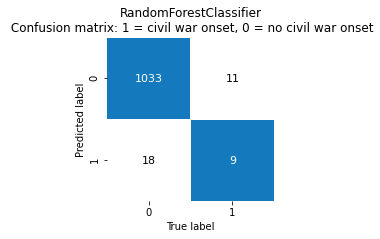

In [118]:
# Random Forests (RF)

pr_auc_rf, roc_auc_rf, f1_rf, grid_rf = fit_predict(X, y, rf, params_rf)

comparison_data_ML_algos['RF'] = {'PR': pr_auc_rf, 'ROC': roc_auc_rf, 'F1': f1_rf}

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   40.8s finished


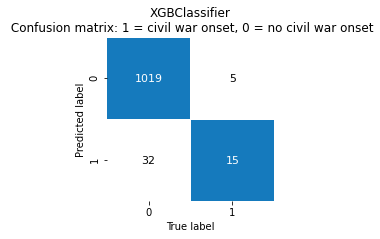

In [119]:
# XGBoost (XGB)

pr_auc_xgb, roc_auc_xgb, f1_xgb, grid_xgb = fit_predict(X, y, xgb, params_xgb)

comparison_data_ML_algos['XGB'] = {'PR': pr_auc_xgb, 'ROC': roc_auc_xgb, 'F1': f1_xgb}

While tree-based methods are usually robust to strong data variance, feature scaling is a necessary preprocessing step for neural networks. Here, continuous variables were standardized to zero mean and unit variance before training.

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.9min finished


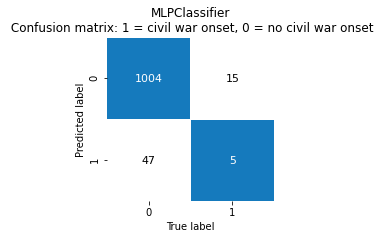

In [120]:
# Multi-layer perceptron (MLP) (here named as neural network (NN))

pr_auc_nn, roc_auc_nn, f1_nn, grid_nn = fit_predict(X, y, nn, params_nn, normalize=True)

comparison_data_ML_algos['NN'] = {'PR': pr_auc_nn, 'ROC': roc_auc_nn, 'F1': f1_nn}

#### Summary evaluation data and PR-AUC plot

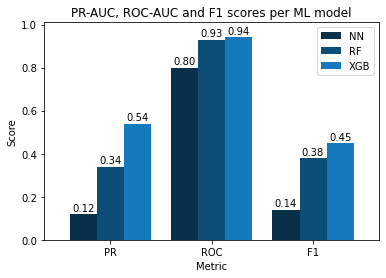

In [121]:
metric_barplot_visualization(comparison_data_ML_algos, 'ML_algos')

Looking at the ROC-AUC results, it seems that the implemented multi-layer perceptron (MLP) performed worse than tree-based methods, as both Random Forests and XGBoost achieved similar scores.

That said, F1 and PR-AUC scores tell a different story with respect to Random Forests' predictive ability. Looking at these metrics, XGBoost was far more robust at predicting civil events than Random Forest, albeit with more Type II errors. The confusion matrices plotted above confirm this observation, as XGBoost was able to correctly classify **15** out of **20** civil war events, while Random Forests and MLP respectively predicted **9** and **5** civil war events. 

Concerning the tree-based methods, these observations are in accord with corrections of Muchlinski et al. [5]'s findings by Wang [7], who found a substantial improvement in PR-AUC using gradient boosted trees in comparison to Random Forests using a similar dataset.

Overall, XGBoost was the best model for this task. In addition to its sheer rapidity, this algorithm has become increasingly popular for its performance in a variety of machine learning challenges [8, 9].

In [124]:
def feature_importance_visualization(grid, X, y, estimator_name,
                                     N=20, seed=seed, scoring='average_precision'):
    
    '''
    Visualize feature importance for a given estimator
    
    Parameters
    ----------
    grid: sklearn.GridSearchCV object
        A sklearn estimator tuned by cross-validated grid-search
    
    X: ndarray
        Feature matrix, can be the training set or the test set (cf. sklearn documentation)
    
    y: ndarray
        Label matrix, can be the training set or the test set (cf. sklearn documentation)
    
    estimator_name: string
        Name of estimator (for figure annotation and saving)
    
    N: int, default=20
        The number of features to plot
    
    seed: int, default=20201106
        A random seed
    
    scoring: str, default="average_precision"
        The scoring function of grid
    '''
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    
    pi_mean = permutation_importance(grid, X, y, random_state=seed, scoring=scoring).importances_mean
    
    sorted_idx = np.argsort(-pi_mean)[:N]
    top_keys = df.drop(['cowcode', 'year', 'warstds'] + geo_cols, axis=1).columns[sorted_idx]
    top_labels = [mapping[key].replace('\n', '').split(';')[0] for key in top_keys]
    
    sns.pointplot(x=pi_mean[sorted_idx], y=top_labels,
                  join=False, color=palette[2], ax=ax)
    ax.set_xlim(left=0) # Minimum score possible: 0
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_title(estimator_name + '\n Permutation importance')
    ax.set_xlabel('Feature importance')
    
    plt.savefig('fig/' + estimator_name + '_PI.png', bbox_inches='tight')
    plt.show()

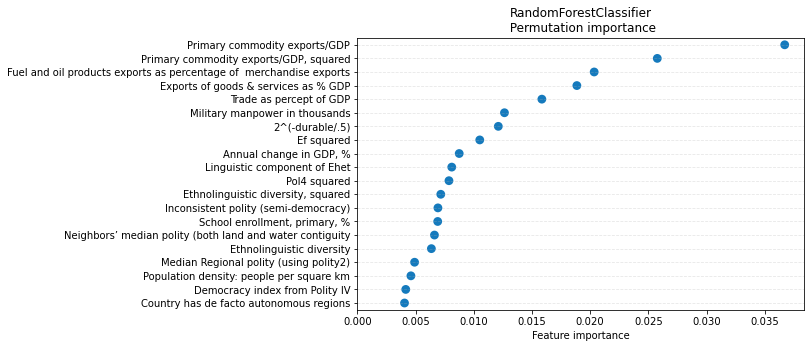

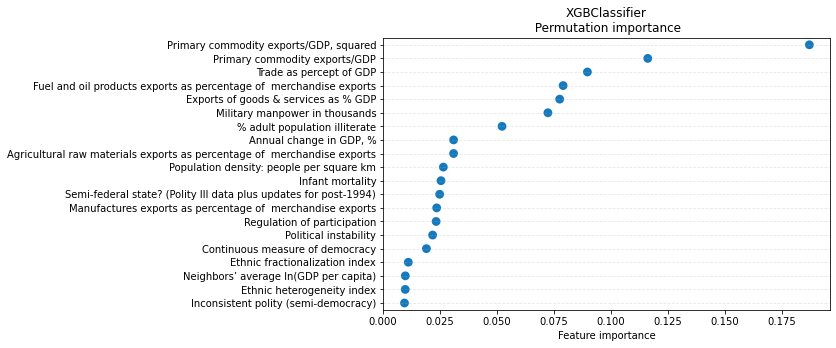

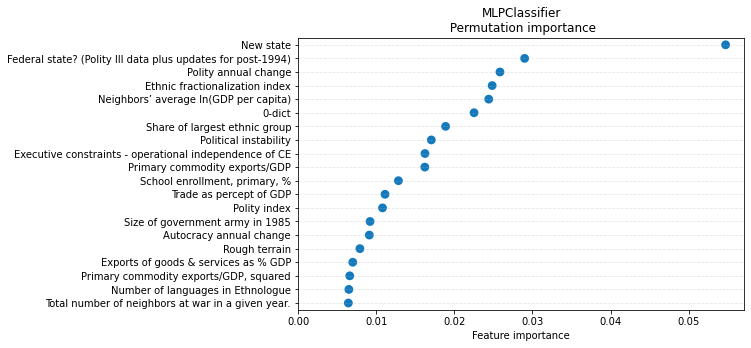

In [123]:
normalize_mask = [False, False, True]
grids = [grid_rf, grid_xgb, grid_nn]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=seed)

for i, grid in enumerate(grids):
    if normalize_mask[i]:
        # Standardize continuous features for MLP
        scaler = StandardScaler()
        non_cat_cols = find_categorical_features(X)
        X_train[:,non_cat_cols] = scaler.fit_transform(X_train[:,non_cat_cols])
        X_test[:,non_cat_cols] = scaler.transform(X_test[:,non_cat_cols])
    
    estimator_name = grid.estimator.steps[-1][-1].__str__().split('(')[0]
    feature_importance_visualization(grid, X_test, y_test, estimator_name)

Feature importance was evaluated via **permutation importance**, which evaluates the mean decrease in a given metric (here, average precision) when permuting the feature values.

In the figures above, we observe that the tree-based decision methods (Random Forests and XGBoost) have similar feature importances. In particular, primary commodity export features, exports of goods and services, fuel exports, the relative amount of trade and the relative amount of military manpower are the top-6 features in both models.

Contrary to the mean decrease in Gini score, this method is robust to feature cardinality. Hence, it is not surprising to observe that some political indicators (e.g., the Polity index or a dummy variable describing whether the state is semi-federal) that were surprisingly absent in Muchlinski et al.'s model [5] are present in the most important features of Random Forests and XGBoost. In spite of this, both methods share a fair amount of important variables with those of Muchlinski et al.'s model [5] (e.g., primary commodity export features, trade, military power, infant mortality, illiteracy).

On the other hand, the multi-layer perceptron captures a lot more political indicators in its most important features, the top-3 features concern the "political structure" of the country (1. Whether it is a new state or not, 2. whether it is a federal state or not, 3. Polity annual change). That said, the trade-related features that were critical in the tree-based models are also present in top 10-20 features of the MLP.

## Step 3: Effect of spatial data separation
---

In this step, we will explore whether spatial separation of civil war data (i.e., by continent or subregion) can help improve predictive accuracy of civil war events.

For this, we will split the datasets according to the dummy variables, and fit a XGBoost classifier for each subset. Once again, cross-validated grid-search will be used to optimize hyperparameters using the training set before evaluation on the test set.

First, let's perform a sanity check by making sure that each row has a 1 in at least of one of the geographical features

In [125]:
# Sum the values of each geographical dummy variable for each row
row_geo_sums = df.loc[:,geo_cols].sum(1)

# Assert that each of these row sums is equal to 1
assert(all(row_geo_sums == 1))

In [126]:
for geo in geo_cols:
    print(f'Number of civil war events in {mapping[geo].split("Region: ")[1]}: {df[df.loc[:,geo] == 1].warstds.sum()}')

Number of civil war events in Western Europe and the US: 1
Number of civil war events in Eastern Europe and Central Asia: 11
Number of civil war events in Middle East and North 
Africa: 19
Number of civil war events in South and East Asia and 
Oceania: 30
Number of civil war events in Latin America: 18
Number of civil war events in Sub-Saharan Africa: 37


One limit of this analysis is that only one civil war event was reported in Western Europe and US (The Troubles in Northern Ireland (1969)) (among 1157 country-years). This is especially problematic as only the train set or the test set could have a positive example. Thus, we decided to ignore this subset. 

With that in mind, we decided to discard this region from this part. On top of this machine learning-driven explanation, this decision is also motivated when looking at economic, social and political indicators. In particular, we selected the five most important features from XGBoost in Step 1, and compared bootstrapped $95\%$ confidence intervals around the mean of these features for each geographical area. We can see that some of the variables are substantially different for Western Europe and US countries, especially primary commodity and fuel exports.

In [127]:
# Helper function

def feature_barplot_visualization(df, label):
    '''
    Visualize time-averaged feature values for each geographical region in a bar plot
    
    The geographical regions are mainly derived from the definition of the IUCN
    
    Parameters
    ----------
    df: pandas.DataFrame
        The civil war dataset
    
    label: string
        The name of a feature to visualize
    '''
    
    # Generate mapped legend for future plotting
    name_to_color = dict(zip([mapping[geo].split('Region: ')[1] for geo in geo_cols], palette))
    patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in name_to_color.items()]
    
    # Generate bar plot
    sns.barplot(y=label, x='geo', data=df, order=sorted(df.geo.unique()), palette=palette)   
    plt.xlabel('Geographical area')
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1))
    plt.title(mapping[label])
    
    # Save figure
    plt.savefig('fig/' + label + '_barplot.png', bbox_inches='tight')
    plt.show()

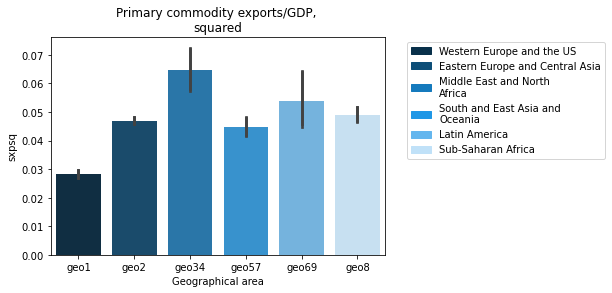

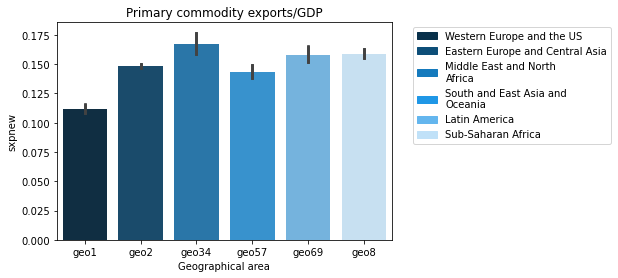

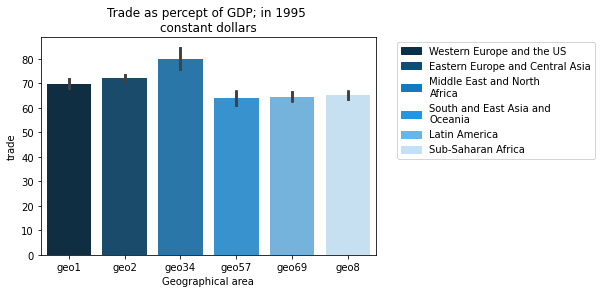

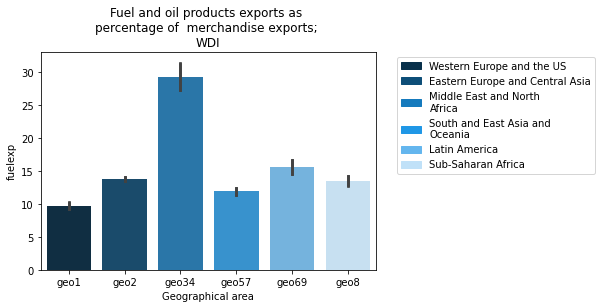

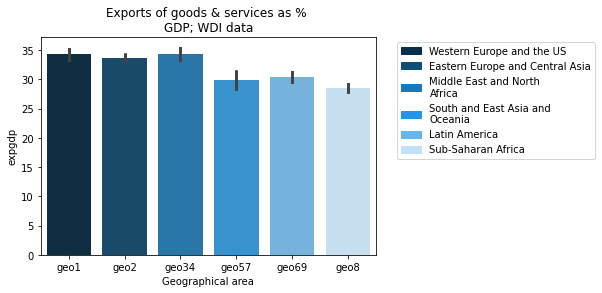

In [128]:
# Build a "geo" column with the name of the geographical area of each country-year
df['geo'] = None

for geo in geo_cols:
    df['geo'] = [geo if x == 1 else df.geo[i] for i, x in enumerate(df.loc[:,geo])]

# 5 most important metrics of XGBoost
metrics = ['sxpsq', 'sxpnew', 'trade', 'fuelexp', 'expgdp']

for metric in metrics:
    feature_barplot_visualization(df, metric)

After discarding Western Europe & US data, let's fit XGBoost on each of them using the same procedure as in Step 1.

################################################################################
Fitting XGBoost for: geo2 (Eastern Europe and Central Asia)
################################################################################
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.0s finished


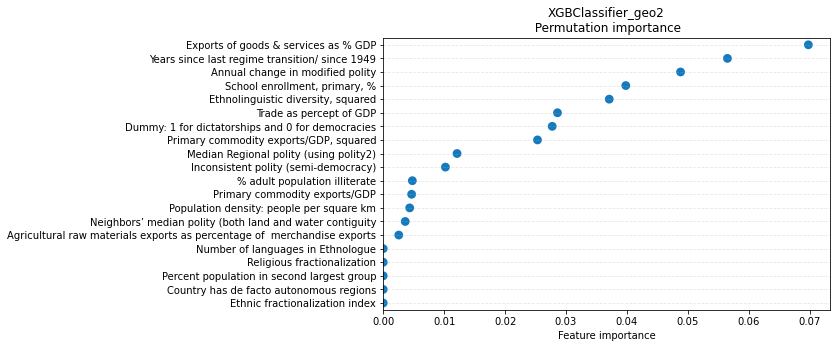

################################################################################
Fitting XGBoost for: geo34 (Middle East and North 
Africa)
################################################################################
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.3s finished


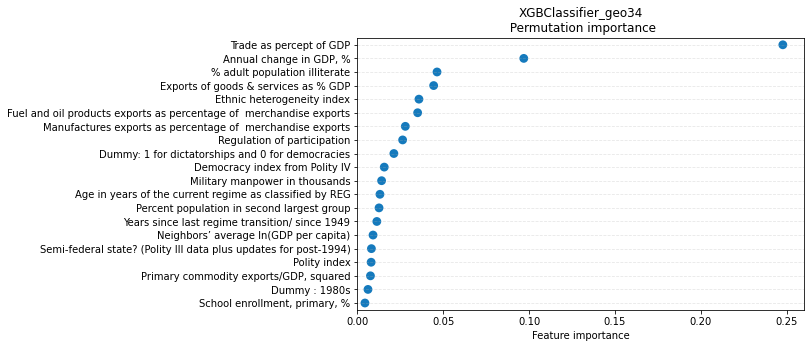

################################################################################
Fitting XGBoost for: geo57 (South and East Asia and 
Oceania)
################################################################################
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.5s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.9s finished


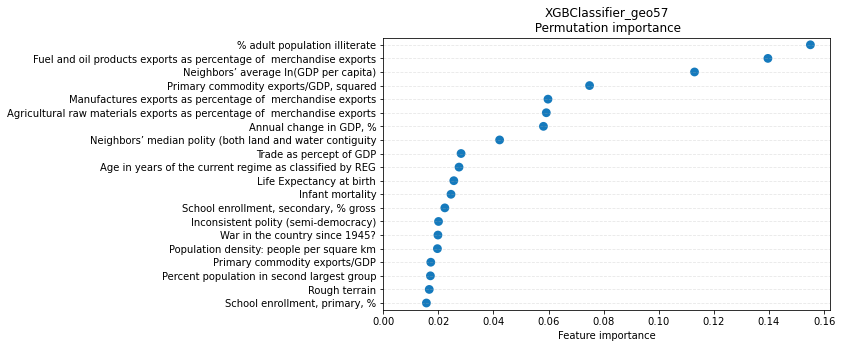

################################################################################
Fitting XGBoost for: geo69 (Latin America)
################################################################################
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.7s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.2s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.0s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.4s finished


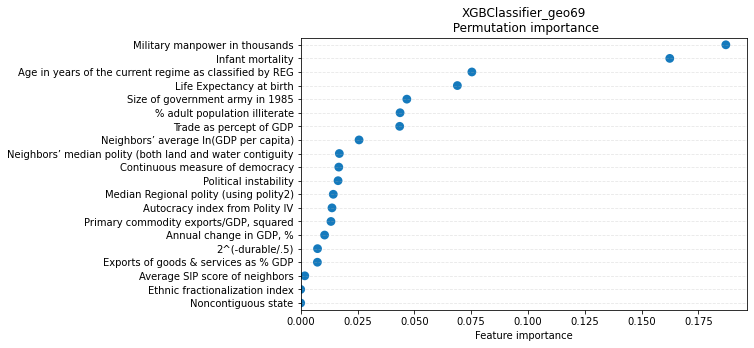

################################################################################
Fitting XGBoost for: geo8 (Sub-Saharan Africa)
################################################################################
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   11.5s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.8s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.6s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.6s finished


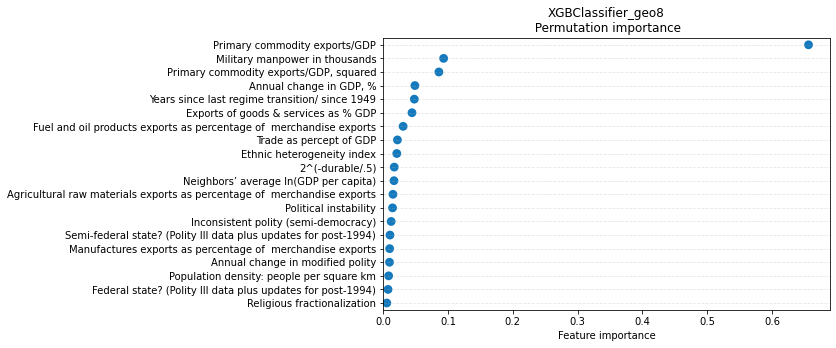

In [146]:
comparison_data_geo_split = {}

n_trials = 10

for geo in geo_cols:
    if geo == 'geo1':
        continue
    
    print(''.join(80*['#']))
    print(f'Fitting XGBoost for: {geo} ({mapping[geo].split("Region: ")[1]})') 
    print(''.join(80*['#']))
    
    geo_df = df[df.loc[:,geo] == 1]
    
    X = geo_df.drop(['warstds', 'year', 'cowcode', 'geo'] + geo_cols, axis=1).values
    
    y = geo_df.loc[:,'warstds']
    
    pr_aucs = np.zeros(n_trials)
    roc_aucs = np.zeros(n_trials)
    f1s = np.zeros(n_trials)
    
    for i in range(n_trials):
        pr_auc, roc_auc, f1, grid = fit_predict(X, y, xgb, params_xgb, 
                                                n_splits=5, test_size=0.15,
                                                seed=seed+i, plotting=False)
        pr_aucs[i] = pr_auc
        roc_aucs[i] = roc_auc
        f1s[i] = f1
    
    comparison_data_geo_split[geo] = {'PR': pr_aucs.mean(), 'ROC': roc_aucs.mean(), 'F1': f1s.mean()}
    
    estimator_name = grid.estimator.steps[-1][-1].__str__().split('(')[0] + '_' + geo
    feature_importance_visualization(grid, X, y, estimator_name)

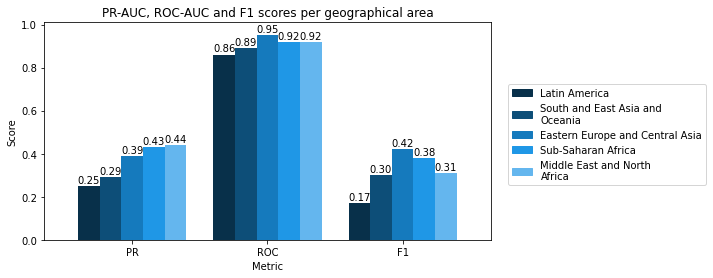

In [77]:
metric_barplot_visualization(comparison_data_geo_split, 'geo_split')

 * After data separation by geographical area, the results datasets are much smaller. As a consequence, the testing sets only contain a handful of positive examples (1 to 5). Thus, we decided to evaluate PR-AUC, ROC-AUC and F1 scores over 5 different train-test splits to minimize "lucky" or "unlucky" examples in the test sets.
 
 * The results for Sub-Saharan Africa, Middle East and North Africa and Eastern Europe and Central Asia are somewhat similar to the performance of XGBoost in Step 1 on the whole dataset, especially when looking at ROC-AUC and F1 scores. On the other hand, the PR-AUC scores are slightly lower ($0.45$-$0.5$) than observed in Step 1 ($0.54$).
 
 * The classifiers of civil war events in Latin America and South and East Asia and Oceania performed much worse. For the latter, PR-AUC, ROC-AUC and F1 values resemble the ones obtained when training the multi-layer perceptron in Step 1.
 
 * Interestingly, the important predictors of civil war onset differed staggeringly over the different geographical areas:
      * In **Eastern Europe and Central Asia**, the three most important features were "Exports of goods & servies as % of GDP", "Years since last regime transition since 1949" and "Annual change in modified polity". The last two variables echo with the fact many countries in these areas were either under the Soviet yoke (e.g., Romania, Afghanistan), and/or also governed by authoritarian regimes nowadays (e.g., Tajikistan, Kazakhstan)
      
      * In **Middle East and North Africa (MENA)**, two trade-related features stood out: "Trade as % of GDP" and "% Annual change in GDP". This observation is consistent with the previous feature bar plots as MENA had the highest country-averaged trade-to-GDP ratio. One can also notice the importance of fuel and oil exports (4th), which are vital to the economy of numerous countries in this region (Saudi Arabia, Iraq, and UAE are among the top-5 countries in terms of crude oil exports [11]).
      * In **South and East Asia and Oceania**, the three most important features were "% adult population illiterate", "Fuel and oil product exports as % of merchandise exports" and "neighbors' average ln(GDP per capita)". Although not visible in the bar plot, the fact that fuel-related variables are important is consistent with the importance of coal in this region. For instance, China and Indonesia are among the top-5 countries in terms of coal exports [12], and were impacted by several civil war events in the 20th century (China: Chinese Civil-War (1945-1949), Indonesia: Papua conflict since 1962). As a rapidly developing region during the second half of the century, it is possible that literacy rates and GDP per capita measurements somehow correlated with civil war onset as most of which occurred soon after the Second World War.
      
      * In **Latin America**, military manpower and children mortality were staggeringly more important than the other variables. The first feature heavily contrasts with feature importances in the other regions. A possible explanation for this feature is the fact that military institutions were often deeply intertwined with political affairs in Latin American countries (e.g., Costa Rican Civil War (1948), Salvdaron Civil War (1979-1992)) [13]. 
      
      * In **Subsaharan Africa**, primary commodity exports/GDP was by far the most critical variable. This results is somewhat consistent with previous analyses by Collier and Hoeffler who found that a high percent of primary commodity exports as a function of GDP was a strong risk factor of civil war onset in Africa [3,14].
 
 * All the same, it seems that geographical area separation did not help better classify civil war events. A possible reason for such results would be that the classifiers were trained with less data, and had thus less generalizing abilities. 

---

 * While possibly contradicting with the results of Muchlinski et al. [5], who found that the US and Western Europe Dummy was an important feature of their Random Forests, this result seems coherent when looking at the mutual information between the different features and the response variable. Indeed, some geographical dummy variables (e.g., geo2 and geo57) are among the variables with the least mutual information with the response variable, meaning that they contain close to no information about civil war onset.

In [79]:
df2 = df.drop(['warstds', 'year', 'cowcode', 'geo'], axis=1)
y = df['warstds'].values

# Find categorical features
mask = find_categorical_features(df2.values)

# Calcualte mutual information between features and target variables
mi = mutual_info_classif(df2, y, discrete_features=mask.astype(int), random_state=seed)

# Identify feature names with no mutual information with the response variable
print('Columns with 0 mutual information with the civil war onset response variable: ')
{col: mapping[col] for col in df2.columns[np.where(mi == 0)]}

Columns with 0 mutual information with the civil war onset response variable: 


{'demch98': 'Democracy annual change; Polity \n98',
 'polch98': 'Polity annual change; Polity98',
 'major': 'Majoritarian system',
 'presi': 'Presidential system',
 'incumb': 'Consolidation of incumbent \nadvantage(Przeworski et al., 2000)',
 'inst': '0-dict; 1-parliam; 2-mixed dem; 3-\npres dem (Przeworski et al., 2000)',
 'dem': 'Dummy: 1 for democracies and 0 \nfor autocracies',
 'drace': 'Racial component of Ehet',
 'geo2': 'Region: Eastern Europe and Central Asia',
 'geo57': 'Region: South and East Asia and \nOceania',
 'decade1': 'Dummy : 1960s',
 'decade4': 'Dummy : 1990s'}

## Step 4: Predicting civil war onset as time series forecasting
---

In this section, we will consider that each country is assigned to a time series of civil war/peace events, and see whether civil war events could be forecast given past data using simple time forecasting models.

Three common techniques are usually employed to study time series: 
 * Recurrent neural networks (RNNs) have become incresingly popular with the deep learning revolution, and have shown tremendous performance in speech recognition or machine translation. Nonetheless, such neural networks generally require a lot of data to be able to avoid overfitting and output robust predictions.
 * Autoregressive methods and Hidden Markov Models (HMMs) are also popular for analyzing time series data. To our best knowledge, they are however not well suited to forecast rare events such as civil war onset.

With that in mind, we decided to (once again) use XGBoost, but this time with time-delayed features. For each country $c$, we aim at predicing civil war onsets at year $t$ $y_{t,c}$ given features from previous years $X_{t-1, c}, X_{t-2, c}, ..., X_{t-N, c}$

#### 4.1 Preparing the dataset

We splitted the dataset for each country, and created sequences of $N$ years for countries with more than $2N$ years of existence. In this project, we assumed that a delay of $N = 5$ years should be the maximal delay to explain civil war onset at a given year, and explored how XGBoost performed on sequences built with $N = 1, ..., 5$

In [78]:
# Group dataframe by country and dispatch groups into list
country_groups = df.groupby(by='cowcode')
country_dfs = [country_groups.get_group(x) for x in country_groups.groups]

# Select countries with at least one civil war event
#cw_country_dfs = [x for x in country_dfs if x.warstds.sum() > 0]

In [79]:
def create_delayed_features(country_dfs, N):
    '''
    Create time-delayed feature sequences for each country in the dataset
    
    Parameters
    ----------
    country_dfs: list
        List of dataframes for each country
    
    N: int
        Time delay in years
        
    Returns
    ----------
    X_seq: ndarray
        The "sequenced" feature matrix, with features at times t-1, ..., t-N
    
    y_seq: ndarray
        Label vector, with civil war onset at times t
    '''
    
    X_seq, y_seq = [], []
    for cwcd in country_dfs:
        # Sanity check: sort dataframe per ascending year
        cwcd = cwcd.sort_values(by='year', axis=0)
        
        # Identify label and feature matrices
        cwcd_Y = cwcd.loc[:,'warstds'] 
        cwcd = cwcd.drop(['cowcode', 'year', 'warstds', 'geo'], axis=1)
        
        # If the country is not at least 2N years old, ignore it
        # (To have sufficient data points for a given country)
        if cwcd.shape[0] <= (N*2):
            continue
        
        # Initialize windowed data
        cwcd_X_windowed = np.zeros((cwcd.shape[0]-N, N, cwcd.shape[1]))
        cwcd_Y_windowed = np.zeros((cwcd.shape[0]-N,))

        for i in range(cwcd.shape[0]-N):
            cwcd_X_windowed[i,:,:] = cwcd.iloc[i:i+N,:].values # Get data from previous years
            cwcd_Y_windowed[i] = cwcd_Y.iloc[i+N] # Append the label for the next year

        X_seq.append(cwcd_X_windowed)
        y_seq.append(cwcd_Y_windowed)
    
    # Concatenate lists into an array
    X_seq = np.concatenate(X_seq)
    y_seq = np.concatenate(y_seq)
    
    # Reshape 3D array to 2D
    X_seq = X_seq.reshape(X_seq.shape[0], -1)

    print(f'Dataset/label dimensions: {X_seq.shape}/{y_seq.shape}')
    print(f'Number of positive events: {y_seq.sum()} ({100*y_seq.mean():.2f})%')
    
    return X_seq, y_seq

In [80]:
# Given the dataset is even more imbalanced that before,
# we added a fourth possible sampling strategy in XGBoost (ratio 1:15)

params_xgb = {'classification__n_estimators': [100],
              'classification__max_depth':[3, 6, 9], # Standard = 6, try 50% and 150% of default value
              'classification__subsample': [2/3, 1], # Equivalent to max_samples 
              'classification__random_state': [seed],
              'classification__booster': ['gbtree'], # Standard booster
              'sampling__sampling_strategy': [0.0625, 0.125, 0.25, 0.5], # Different downsampling strategies
              'sampling__random_state': [seed]
             }

Dataset/label dimensions: (6962, 88)/(6962,)
Number of positive events: 104.0 (1.49)%
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.2min finished


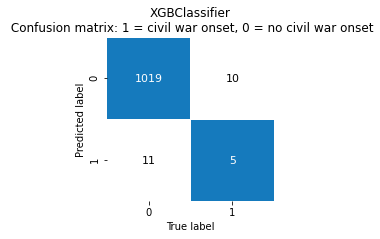

Dataset/label dimensions: (6784, 176)/(6784,)
Number of positive events: 98.0 (1.44)%
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.8min finished


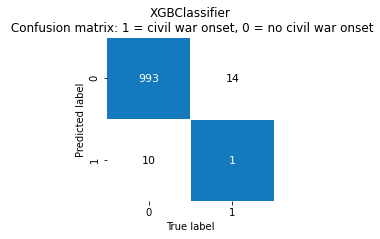

Dataset/label dimensions: (6603, 264)/(6603,)
Number of positive events: 95.0 (1.44)%
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.6min finished


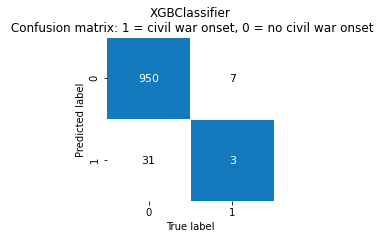

Dataset/label dimensions: (6410, 352)/(6410,)
Number of positive events: 90.0 (1.40)%
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  3.2min finished


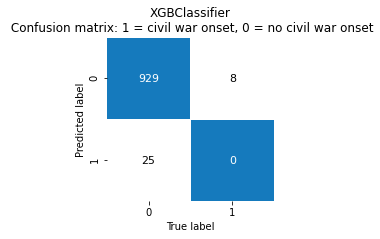

Dataset/label dimensions: (6143, 440)/(6143,)
Number of positive events: 84.0 (1.37)%
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.5min finished


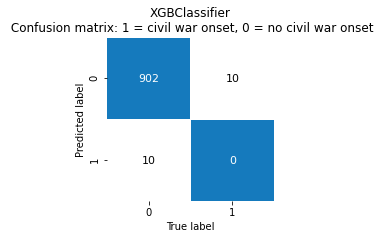

In [82]:
comparison_data_time_delayed = {}

for N in range(1,6):
    X_seq, y_seq = create_delayed_features(country_dfs, N)
    
    pr_auc_xgb, roc_auc_xgb, f1_xgb, _ = fit_predict(X_seq, y_seq, xgb, params_xgb, test_size=0.15)
    
    comparison_data_time_delayed[str(N)] = {'PR': pr_auc_xgb, 'ROC': roc_auc_xgb, 'F1': f1_xgb}

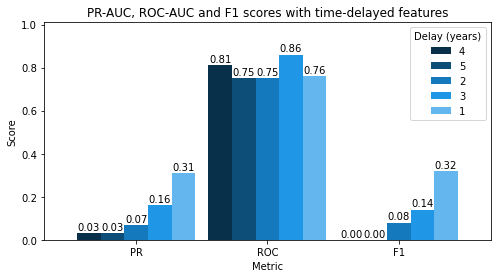

In [99]:
metric_barplot_visualization(comparison_data_time_delayed, 'time_delayed')

When looking at imbalance-robust metrics (PR-AUC and F1 scores), the best model seems to be obtained with $N = 1$, that is only considering the data from the previous year. In this configuration, $5$ out of $15$ civil war events could be predicted given features from the previous year. A possible explanation for such a result is that most variables will tend to remain similar over a year, while greater change can be expected when considering more ancient data.

Overall, the prediction results remain arguably worse than during the two previous steps. That said, this task is also conceptually harder. Indeed, many civil war events are not continuous process, but rather tend to spark spontaneously. For instance, the Arab Spring suddenly triggered several uprisings in Syria, Libya and Egypt in 2011 [10]. 

To our best knowledge, very little research has been done on time-series forecasting of civil war events. With that in mind, we think that further research for this task should be performed with larger datsets, if possible, (e.g., with country-months instead of country-years) to be able to exploit the power of recurrent neural networks.

### References

[1] Pettersson, T., & Öberg, M. (2020). Organized violence, 1989–2019. _Journal of peace research_, 57(4), 597-613.

[2] Fearon, J. D., & Laitin, D. D. (2003). Ethnicity, insurgency, and civil war. _American political science review_, 75-90.

[3] Collier, P., & Hoeffler, A. (2004). Greed and grievance in civil war. _Oxford economic papers_, 56(4), 563-595.

[4] Hegre, H., & Sambanis, N. (2006). Sensitivity analysis of empirical results on civil war onset. _Journal of conflict resolution_, 50(4), 508-535.

[5] Muchlinski, D., Siroky, D., He, J., & Kocher, M. (2016). Comparing random forest with logistic regression for predicting class-imbalanced civil war onset data. _Political Analysis_, 87-103.

[6] Davis, J., & Goadrich, M. (2006). The relationship between Precision-Recall and ROC curves. In _Proceedings of the 23rd international conference on Machine learning_ (pp. 233-240).

[7] Wang, Y. (2019). Comparing random forest with logistic regression for predicting class-imbalanced civil war onset data: A comment. _Political Analysis_, 27(1), 107-110.

[8] Chen, T., & He, T. (2015). Higgs boson discovery with boosted trees. In _NIPS 2014 workshop on high-energy physics and machine learning_ (pp. 69-80).

[9] Ismailov, A. (2019). Humor Analysis Based on Human Annotation Challenge at IberLEF 2019: First-place Solution. In _IberLEF@ SEPLN_ (pp. 160-164).

[10] Henry, C., & Jang, J. H. (2013). _The Arab Spring: Will it Lead to Democratic Transitions?_ Springer.

[11] Central Intelligence Agency. (2018). The World Factbook - country comparison:: crude oil - exports. https://www.cia.gov/library/publications/the-world-factbook/rankorder/2242rank.html

[12] U.S. Energy Information Administration (EIA). (2018). Total energy production from coal 2018. https://www.eia.gov/international/rankings/country/CHN?pid=4411&aid=1&f=A&y=01%2F01%2F2018&u=0&v=none&pa=286

[13] Encyclopædia Britannica. (2019). History of Latin America - Latin America since the mid-20th century. https://www.britannica.com/place/Latin-America/Latin-America-since-the-mid-20th-century

[15] Collier, P., & Hoeffler, A. (2002). On the incidence of civil war in Africa. _Journal of conflict resolution_, 46(1), 13-28.